## Hecho por: David Ramírez Betancourth
## C.C. 1002636667
## Ingeniería Electrónica
## Universidad Nacional de Colombia Sede Manizales

In [42]:
import matplotlib.pyplot as plt #Graficador
import numpy as np #Opearciones entre arrays
import scipy.signal as sig #métodos de señales (welch)


import tensorflow as tf # Red Neuronal
from sklearn.model_selection import train_test_split #Divisor de datos de entrenamiento y testeo
from sklearn.preprocessing import MinMaxScaler #Normalizador de escala
from tensorflow.keras.models import Sequential #Red Neuronal
from tensorflow.keras.layers import Dense, Dropout #Conexión neuronas
from tensorflow.keras.optimizers import Adam #Optimizador de red

#Generar Señal

$f_o = 1 Hz$

$x(t) = cos(\omega_o) - \frac{sin(3\omega_o)}{3} + \frac{cos(5\omega_o)}{5}$

$\xi(t) = x(t) + \eta(t)$

Aplicar método welch: Consiste en hallar la FFT por ventaneos de la señal y luego promediando las PSD de cada segmento

In [43]:
np.random.seed(0)

def randomvector(N, sigma):
    """Genera un vector gaussiano eta = N(0, sigma)"""

    return np.random.normal(0, np.sqrt(sigma), size=N) 

def real_signal(t, wo):
    """x(t)"""

    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)


def welch_vector(X, fs, nperseg):
    """Generar psd de la señal xi
       ventaneo hamming
       overlap del 25% de la vetana
    """

    return sig.welch(X, fs, window='hamming', nperseg=nperseg, noverlap=(nperseg*.25))

N = 1024 #Longitud señal
M = 2000 # No de señales
fo = 1 # 1Hz frecuencia
wo = 2*np.pi*fo
sigma = 0.1  #varianza
nperseg = 501 #Longitud ventana

t = np.linspace(0, 3, N) # vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0]) #Muestreo

X = np.zeros((M, N)) #Matriz vacía de zeros
for i in range(M):
    X_true = real_signal(t, wo) #Generar señal real
    X[i] = X_true + randomvector(N, sigma) #Combinarla con ruido, meterla a la fila

Psd = np.zeros((M, (nperseg//2)+1)) # Matriz welch, M señales, longitud psd = (ventaneo//2) +1
Freq = np.zeros((M, (nperseg//2)+1))

for i in range(M):
    f, psd = welch_vector(X[i], fs, nperseg)
    Psd[i] = psd
    Freq[i] = f


(251,)
(251,)


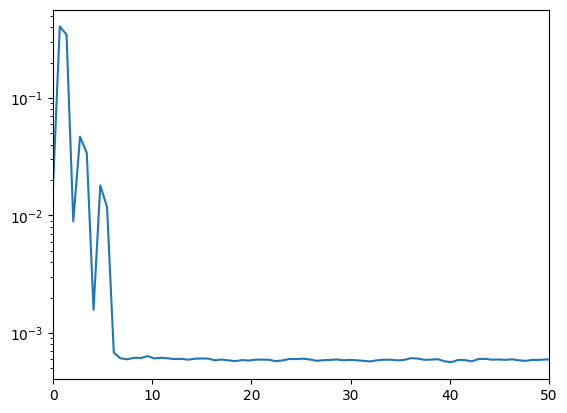

In [44]:
Psd_mean = np.mean(Psd, axis=0)
Freq_mean = np.mean(Freq, axis=0)

Psd_mean_m = np.zeros((M, (nperseg//2)+1))

for i in range(M):
    Psd_mean_m[i] = Psd_mean

print(Psd_mean.shape)
print(Freq_mean.shape)

plt.semilogy(Freq_mean, Psd_mean_m[0])
plt.xlim([0, 50])
plt.show()

# Preparar Datos

Scaler: normaliza los datos a una escala deseada (0,1)

train test split: Divide los datos un porcentaje deseado 70/30, 70 entrenar, 30 test.

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))

X = scaler.fit_transform(X)
Psd_mean_m = scaler.fit_transform(Psd_mean_m)



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Psd_mean_m, test_size=0.3, random_state=42)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1400, 1024)
(600, 1024)
(1400, 251)
(600, 251)


# Red Neuronal

Modelo tipo Sequential(MLP): Las capas se apilan una tras otra, lo que hace que el flujo de datos sea simple y directo. Es MLP porque contiene perceptrones. Capa de entrada - capa oculta - capa de salida. Configuración Dense.

Optimizador Adam: Utiliza AdaGrad y RMSProp. Consiste en:
- Calcular Gradiente
- Se corrige sesgos
- Se actualizan pesos
 



In [47]:
model = Sequential([
    tf.keras.Input(shape=(N,)), #Capa de entrada
    Dense(N//2, activation='relu'), #Capa oculta
    Dropout(0.5), #Dropout para no sobreajuste
    Dense(N//4, activation='relu'), # Capa oculta
    Dense(128, activation='relu'), #Capa oculta
    Dense(nperseg//2 + 1) #Capa de salida
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy']) #Optimizador adam, 

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 8.4547e-04 - loss: 0.0348 - val_accuracy: 0.0036 - val_loss: 1.7164e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.5657e-04 - loss: 0.0012 - val_accuracy: 0.0036 - val_loss: 5.3645e-05
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0048 - loss: 4.4608e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.0946e-05
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 5.4480e-04 - loss: 2.3802e-04 - val_accuracy: 0.0036 - val_loss: 2.1502e-05
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 7.5134e-05 - loss: 1.5403e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.6596e-05
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 1.0882e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.3943e-05
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0014 - loss: 7.8489e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.1616e-05
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━

# Rendimiento del Modelo

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 2.3370e-08 
Test Loss: 2.7907578470376393e-08, Test MAE: 0.0


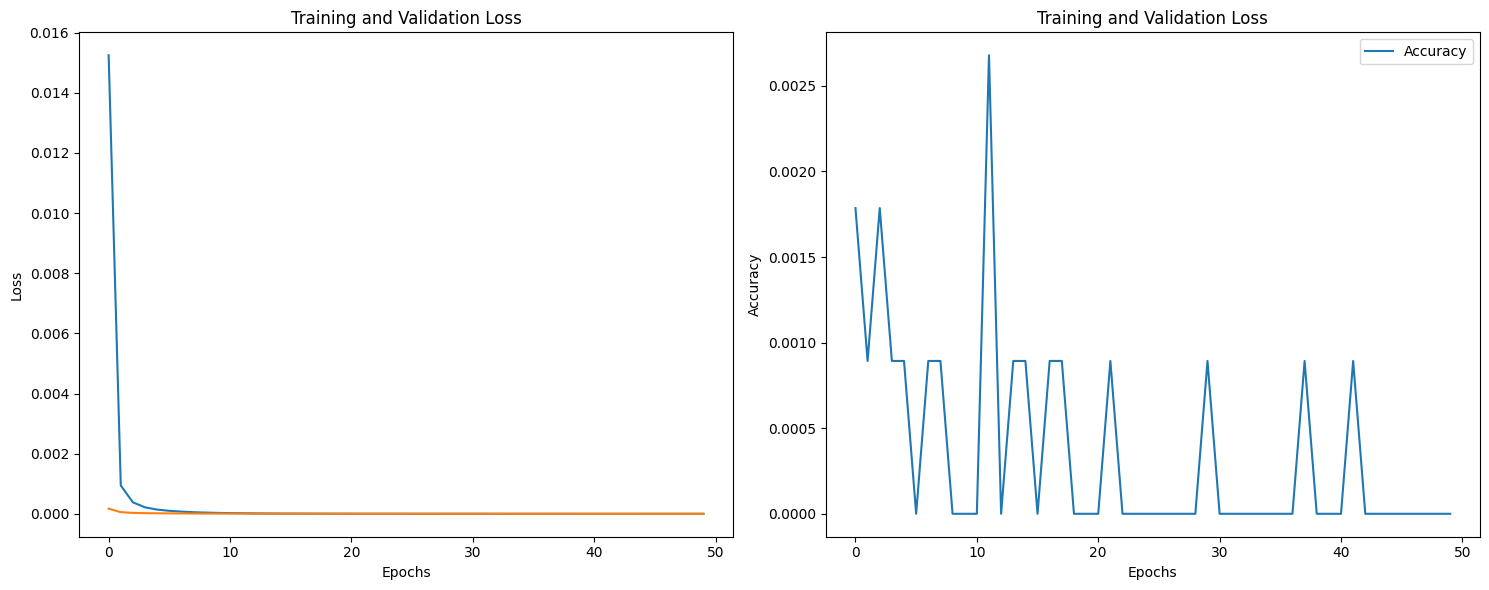

In [48]:
# Evaluar modelo
loss, mae = model.evaluate(X_test, y_test) #Saca mae = promedio del error absoluto y pérdidas del modelo
print(f"Test Loss: {loss}, Test MAE: {mae}")


fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(history.history['accuracy'], label='Accuracy')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Predecir

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


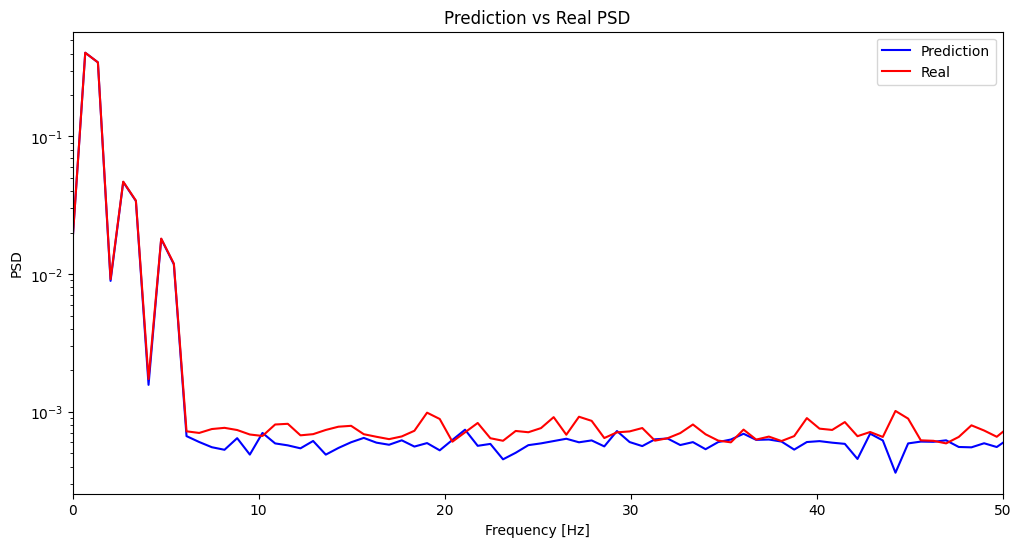

In [49]:
psd_pred = model.predict(X_test)
psd_pred = scaler.inverse_transform(psd_pred)

psd_real = np.zeros((M, (nperseg//2)+1))
for i in range(X_test.shape[0]):
    f, psd = welch_vector(X_test[i], fs, nperseg)
    psd_real[i] = psd
psd_real = scaler.inverse_transform(psd_real)

plt.figure(figsize=(12, 6))
plt.semilogy(f, psd_pred[50], color='b', label='Prediction')
plt.semilogy(f, psd_real[50], color='r', label='Real')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Prediction vs Real PSD')
plt.legend()
plt.xlim([0,50])
plt.show()